In [159]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import librosa

In [160]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# set fonttype
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

%matplotlib inline

In [161]:
# do not forget to choose CUDA runtime!
device = torch.device('cuda:0')

In [162]:
# fix seeds for reproducbility
np.random.seed(42);
torch.random.manual_seed(42);

### Scaled Dot Product Attention
---

В оригинальной работе [Attention Is All You Need](https://arxiv.org/abs/1706.03762) в качестве механизма внимания
был использован scaled dot product attention - нормализованное скалярное произведение между key и query.
На вход подается набор запросов $Q\in\mathbb{R}^{L\times d_k}$, ключей $K\in\mathbb{R}^{L\times d_k}$  и
значений  $V\in\mathbb{R}^{L\times d_v}$, где $L$ - длина последовательности, а $d_k, d_v$ - размерности query/key и value соотвественно.
Значение attention от элемента $i$ на элемент $j$ зависит от похожести query $q_i$ и key $k_j$. Attention определяется по следующей формуле:

$$ \text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Произведение матриц $Q K^{T}$ составлено из всех попарных скалярных произведений ключей и значений.


<p align="center">
  <img src="scaled_dot_product_attn.png" width="300"/>
</p>

Дополнительно в операцию может входить бинарная маска $M \in \{0, 1\}$, зануляющая некоторые элементы в матрице attention, если по некоторой причине мы не хотим, чтобы токен $i$ из query взаимодействовал c $j$ из key. Это может быть полезно при генерации последовательностей, когда мы не хотим, чтобы данный токен смотрел вперед, на еще не сгенерированные элементы.


Деление на $\sqrt{d_k}$ необходимо, что выход операции сохранял дисперсию распределения, т.к:
$$
q_i \sim \mathcal{N}(0, 1), k_i \sim \mathcal{N}(0, 1) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = d_k
$$

**Задание 1 (0.1 балла):**. Реализуйте операцию scaled dot product.

In [163]:
def scaled_softmax_attention(query, key, value):
    """
    Args:
        query: torch.Tensor (..., L, D)
        key: torch.Tensor (..., L, D)
        value: torch.Tensor (..., L, D)
    Returns:
        res: torch.Tensor (..., L, D), output of the attention layer (\softmax(Q K^T / d) V
        attention: torch.Tensor (..., L, L), attention weights (\softmax(Q K^T / d))

    L is the length of sequence, D is the embedding dimension
    """

    attention = F.softmax((query @ key.transpose(-2, -1) / math.sqrt(key.size(dim=1))), dim=-1)
    res = attention @ value

    return res, attention

In [164]:
query = torch.tensor([[ 0.3367,  0.1288,  0.2345,  0.2303],
                      [-1.1229, -0.1863,  2.2082, -0.6380],
                      [ 0.4617,  0.2674,  0.5349,  0.8094]])
key   = torch.tensor([[ 1.1103, -1.6898, -0.9890,  0.9580],
                      [ 1.3221,  0.8172, -0.7658, -0.7506],
                      [ 1.3525,  0.6863, -0.3278,  0.7950]])
value = torch.tensor([[ 0.2815,  0.0562,  0.5227, -0.2384],
                      [-0.0499,  0.5263, -0.0085,  0.7291],
                      [ 0.1331,  0.8640, -1.0157, -0.8887]])

In [165]:
query @ torch.transpose(key, 0, 1)

tensor([[ 0.1449,  0.1980,  0.6500],
        [-3.7271, -2.8490, -2.8776],
        [ 0.3072, -0.1882,  1.2761]])

In [166]:
res, attn = scaled_softmax_attention(query, key, value)

**Sanity check**.

Матрица attn должна быть размера $(L, L)$ и столбцы должны суммироваться в 1.

In [167]:
attn.shape

torch.Size([3, 3])

In [168]:
attn.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000])

In [169]:
true_res = torch.tensor([[0.1212, 0.5156, -0.2394, -0.1912],
                             [0.0999, 0.5376, -0.2558, -0.1143],
                             [0.1348, 0.5492, -0.3327, -0.3267]])

true_attn = torch.tensor([[0.3017, 0.3098, 0.3884],
                          [0.2451, 0.3801, 0.3748],
                          [0.2938, 0.2293, 0.4769]])
res, attn

(tensor([[ 0.1212,  0.5156, -0.2394, -0.1912],
         [ 0.0999,  0.5376, -0.2558, -0.1143],
         [ 0.1347,  0.5492, -0.3328, -0.3267]]),
 tensor([[0.3017, 0.3098, 0.3884],
         [0.2451, 0.3802, 0.3748],
         [0.2938, 0.2293, 0.4769]]))

### Multihead Attention Layer
---

Scaled dot product attention задает правило, по которому элементы последовательности взаимодейтсвуют друг с другом. Но может быть полезно задавать несколько различных правил взаимодействия. Поэтому последовательности $Q, K, V$ разбиваются на $h$
частей вдоль размерности эмбединнга, и для каждой из них независимо считаем attention, а затем конкатенируем результат. К сконкатенированному результату применяется линейное преобразование $W_O$:

$$
\begin{split}\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}\end{split}
$$

Обучаемыми параметрами являются матрицы проекции $W_Q, W_K, W_V$ и $W_O$.
Ниже приведен граф вычислений:
<p align="center">
  <img src="multihead_attention.png" width="300"/>
</p>

**Задание 2 (0.1 балла):**. Реализуйте класс  `MultiheadAttention`, реализующий операции, описанные выше.

<span style="color:red">Замечание</span>.

Обратите внимание, что слои `q_proj`, `k_proj`, `v_proj` создают последовательность для всех голов одноновременно, то есть их выходная размерность должна быть $\mathbb{R}^{d_{embed}}$, а не $\mathbb{R}^{d_{embed} / h}$.

In [170]:
class MultiheadAttention(nn.Module):

    def __init__(self, embed_dim, num_heads):
        """
        Args:
            embed_dim: dimensionality of embedding (total)
            num_heads: number of heads (must divide embed_dim)
        """
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        # Финальный проекционный слой
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    # original implementation uses this initialization
    def _reset_parameters(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)

    def forward(self, x, return_attention=False):
        """
        Args:
            x: torch.Tensor (B, L, D)
            return_attention: If specified, returns attention along with outputs
        Returns:
            outputs: torch.Tensor (B, L, D)
            attention: Optional[torch.Tensor] (B, num_heads, L, L)

        B is batch size, L is the length of sequence, D is the embedding dimension
        """
        batch_size = x.size(dim=0)

        q = self.q_proj(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        outputs, attention = scaled_softmax_attention(q, k, v)
        # Конкатенация всех голов и применение финального линейного слоя
        outputs = outputs.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        outputs = self.o_proj(outputs)
        if return_attention:
            return outputs, attention
        else:
            return outputs

In [171]:
multihead_attention = MultiheadAttention(4, 2)

In [172]:
inputs  = torch.stack([torch.cos(i * torch.ones(4)) for i in range(3)])[None, ...]

with torch.no_grad():
    outputs = multihead_attention(inputs)

inputs.shape

torch.Size([1, 3, 4])

### Encoder Block
---

Архитектура трансформера в оригинальной статье состоит из последовательности блоков энкодера и декодера.

<p align="center">
  <img src="transformer_architecture.png" width="300" />
</p>

В данной МДЗ необходимо будет реализовать только энкодер.

Блок энкодера состоит из операции `MultiheadAttention` и применения `FeedForward` сети к каждому токену по отдельности.

К выходу `MultiheadAttention` и `FeedForward`
прибавляется skip connection, и к полученной сумме применяется `LayerNormalization`.

В качестве `FeedForward` сети берется простая двуслойная сеть с некоторой активацией (обычно  `ReLU` или `GELU`).

Таким образом, энкодер выполняет следующее:
$$
x = \text{LayerNorm}(x+\text{MultiheadAttention}(x,x,x))
$$
$$
\begin{split}\begin{split}
    \text{FFN}(x) & = \mathrm{Act}(x W_1 + b_1) W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}\end{split}
$$

В целях регуляризации на выход `MultiheadAttention` и `FeedForward`, но перед `LayerNorm` можно накинуть `Dropout`.

**Задание 3 (0.1 балла):**. Реализуйте класс  `EncoderBlock`, реализующий операции, описанные выше.

In [173]:
class EncoderBlock(nn.Module):

    def __init__(self, embed_dim, num_heads, feedforward_dim, activation=nn.ReLU(), dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            feedforward_dim - Dimensionality of the hidden layer in the MLP
            activation - activation function in FFN
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.feedforward_dim = feedforward_dim
        self.activation = activation
        self.dropout = dropout
        self.FeedForward = nn.Sequential(
            nn.Linear(embed_dim, feedforward_dim),
            activation,
            nn.Linear(feedforward_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.multihead_attention = MultiheadAttention(embed_dim, num_heads)


    def forward(self, x, return_attention=False):
        """
        Args:
            x: torch.Tensor (B, L, D)
        Returns:
            outputs: torch.Tensor (B, L, D)
            attention: Optional[torch.Tensor] (B, num_heads, L, L)
        """

        var_out, var_att = self.multihead_attention(F.layer_norm(x, x.shape[1:]), return_attention=True)
        if self.dropout:
            var_out = F.dropout(var_out, self.dropout)
        var_out += x
        var_out = F.layer_norm(var_out, var_out.shape[1:])
        var_out = self.FeedForward(var_out)
        var_out += x



        outputs, attention = var_out, var_att

        if return_attention:
            return outputs, attention
        else:
            return outputs



### Positional Encoding
---

Описанная выше конструкция очень гибкая и универсальная в плане возможности преобразования последовательностей.
Но есть один нюанс: абсолютное положение токенов никак не определено в текущей форме, и операция `EncoderBlock`
обладает перестановочной симметрией. То есть, если переставить токены в последовательности, то выход от переставленной последовательности будет таким же, как если прогнать исходную последовательность, а затем ее переставить.

Сгенерируем рандомную последовательность.

In [174]:
encoder_block = EncoderBlock(embed_dim=24, num_heads=3, feedforward_dim=24 * 4, dropout=0.0)

In [175]:
inputs = torch.randn(1, 16, 24)

Выход от исходной последовательности

In [176]:
outputs = encoder_block(inputs)

Сгенерируем случайную перестановку

In [177]:
ids_perm = torch.randperm(inputs.size(1))
shuffled_inputs = inputs[:, ids_perm, :]

Посчитаем выход для переставленной последовательности

In [178]:
shuffled_outputs = encoder_block(shuffled_inputs)

И сравним переставленный выход исходной последовательности с выходом переставленной

In [179]:
torch.allclose(outputs[:, ids_perm, :], shuffled_outputs, atol=1e-4, rtol=1e-4)

True

Вуаля! Совпадают.

Но во многих задачах важен порядок, и чтобы его каким-то образом учесть добавляют так называемый PositionalEncoding, который явно задает информацию о положении токена в последовательности. Он может быть как обучаемым, так и зафиксированным.
В оригинальной работе Attention is all you need был выбран следующий энкодинг и синусов и косинусов разных частот:

$$
\begin{split}PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}\end{split}
$$

$PE_{(pos,i)}$ обозначает позиционный энкодинг токена в позиции $pos$, а $i$ нумерует размерность эмбеддинга.

**Задание 4 (0.1 балла):**. Реализуйте класс  `PositionalEmbedding`, добавляющий позиционный энкодинг определенный выше к входной последовательности.

In [180]:
class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim, max_len: int = 5000):
        """
        Inputs
            embed_dim - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()
        # Создаем матрицу позиционных кодировок заранее
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # register_buffer => Tensor which is not a parameter, but should be part of the module's state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        """
        Inputs
            x - Tensor of shape [batch_size, seq_len, embed_dim]
        """
        # Добавляем позиционные кодировки к каждому эмбеддингу
        x = x + self.pe[:, :x.size(1)]
        return x

Визуализируем энкодинг

In [181]:
positional_encoding = PositionalEncoding(embed_dim=64, max_len=128)
pe = positional_encoding.pe[0]

In [182]:
pe = positional_encoding.pe.numpy()[0]

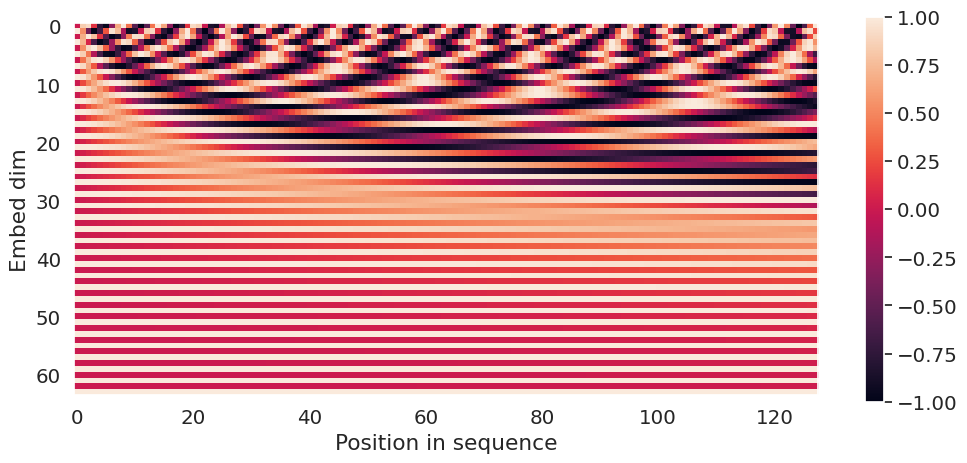

In [183]:
fig, ax = plt.subplots(figsize=(12, 5))

im = ax.imshow(pe.T)
ax.grid(False)

ax.set_ylabel(r'Embed dim')
ax.set_xlabel(r'Position in sequence')

fig.colorbar(im, ax=ax);

### Transformer
---

Теперь у нас есть все необходимые компоненты, чтобы собрать трансформер своими руками.
Сам по себе трансформер может выполнять великое множество задач, но в рамках данной МДЗ мы ограничимся задачей классификации последовательностей.

Архитектура состоит из следующих компонент:
- Линейное преобразование входной последовательности : $\mathbb{R}^{d_{in}} \rightarrow \mathbb{R}^{d_{embed}}$, примененное поэлементно к каждому токену
- Один или несколько блоков `EncoderBlock`
- `PositionalEmbedding`
- Для задачи классификации создается специальный токен `[CLS]`, который прибавляется в начало (или конец последовательности)
- `[CLS]` токен, пропущенный через последовательность, подается на вход классификатора (скажем, линейного слоя $\mathbb{R}^{d_{embed}} \rightarrow \mathbb{R}^{|C|}$, $|C|$ - число классов).

**Задание 5 (0.2 балла):** Реализуйте класс  `TransformerForSequenceClassification`, принимающий на вход последовательность и предсказывающий ее класс.

In [184]:
class TransformerForSequenceClassification(nn.Module):

    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        num_classes: int,
        num_heads: int,
        feedforward_dim: int,
        num_layers: int,
        activation = nn.GELU,
        max_len: int = 5000,
        dropout: float = 0.0
    ):
        super().__init__()
        # define layers
        self.cls_token = torch.randn(embed_dim) # TODO create vector of size (embed_dim,) from N(0, 1)
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len)
        self.multh_att = MultiheadAttention(embed_dim, num_heads)
        encoder_blocks = [EncoderBlock(embed_dim, num_heads, feedforward_dim, activation(), dropout) for _ in range(num_layers)]
        self.encoder = nn.Sequential(*encoder_blocks,)

        self.classifier = nn.Linear(embed_dim, num_classes,)

    def forward_attention(self, x):
        """
        This method returns attention maps from all encoder blocks

        Args:
            x: torch.Tensor (B, L, |V|)
        Returns:
            attn: List[torch.Tensor] (B, num_heads, L+1, L+1) x num_layers
        """
        attn_maps = []
        for layer in self.encoder.layers:
            _, attn = self.multh_att(x, return_attention = True)
            attn_maps.append(attn)
        return attn_maps

    def forward(self, x):
        """
        Args:
            x: torch.Tensor (B, L, |V|)
        Returns:
            x: torch.Tensor (B, |C|)
        """


        embed_x = self.input_embedding(x)
        pos_x = self.positional_encoding(embed_x)
        cls_tokens = self.cls_token.repeat(pos_x.size(0), 1, 1).to(device)
        pos_x = torch.cat((cls_tokens, pos_x), dim=1)

        encode_x = self.encoder(pos_x)


        cls_vector = encode_x[:, -1, :]
        x = self.classifier(cls_vector)

        return x

### Data
---
В данной МДЗ в качестве задачи, которой мы будем обучать трансформер, является определение того, является ли строка палиндромом. То есть тождественна ли строка, написанная задом наперед, исходной строке.

$$
a b f g a a g f b a \quad \mathrm{\ is \ a \ palindrome}
$$

Последовательности генерируются случайным образом из некоторого слова размера `vocab_length`.

In [185]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import numpy as np
import librosa
import torch
import os
from tqdm.notebook import tqdm


here = os.getcwd()
file_dir = os.path.join(here, "train")
path1 = "/kaggle/input/trainn"
file_dir


class MP3Data(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.3
    
    def __init__(self, path_to_data, path_to_csv, train=True, transform=None, max_size=619):
        super().__init__()
        self.path_to_data = path_to_data
        self.path_to_csv = path_to_csv
        self.is_train = train
        self.transform = transform
        self.max_size = max_size
        
        self.file_names = []
        self.lables = []
        
        df = pd.read_csv(self.path_to_csv, header=None)
        data = dict(zip(df[0], df[1]))
        
        file_names = list(data.keys())
        
        train_files, test_files = train_test_split(file_names, random_state=self.SPLIT_RANDOM_SEED,
                                                       test_size=self.TEST_SIZE)
        
        if train:
            self.lables = [data[key] for key in train_files]
            self.files = train_files
            opened_files = []
            for file in tqdm(self.files):
                file_path = self.path_to_data + "/" + file
                y, sr = librosa.load(file_path, sr=None)
                mfccs = torch.tensor(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13))
                pad_size = self.max_size - mfccs.shape[1]
                mfccs = F.pad(mfccs, (0, pad_size), "constant", 0)
                opened_files.append(mfccs)
            self.files = opened_files
        else:
            self.lables = [data[key] for key in test_files]
            self.files = test_files
            opened_files = []
            for file in tqdm(self.files):
                file_path = self.path_to_data + "/" + file
                y, sr = librosa.load(file_path, sr=None)
                mfccs = torch.tensor(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13))
                pad_size = self.max_size - mfccs.shape[1]
                mfccs = F.pad(mfccs, (0, pad_size), "constant", 0)
                opened_files.append(mfccs)
            self.files = opened_files
        
    def __len__(self):
        return len(self.lables)
    
    def __getitem__(self, item):
        file, lable = self.files[item], self.lables[item]    
        return file, lable

train_dataset = MP3Data('/kaggle/input/data-for-cpm/train/train', '/kaggle/input/data-for-cpm/AI Challenge Ground Truth.csv')
test_dataset = MP3Data('/kaggle/input/data-for-cpm/train/train', '/kaggle/input/data-for-cpm/AI Challenge Ground Truth.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

  0%|          | 0/6162 [00:00<?, ?it/s]

  0%|          | 0/6162 [00:00<?, ?it/s]

Созданим обучающую и тестовую выборку

In [186]:
# training hyperparameters
batch_size = 128
num_workers = 2

In [187]:
# model hyperparams
embed_dim =  1024
num_heads =  32
feedforward_dim =  2024

num_layers = 20

In [188]:
model = TransformerForSequenceClassification(
    num_classes=1,
    input_dim=619,
    embed_dim=embed_dim,
    num_heads=num_heads,
    feedforward_dim=feedforward_dim,
    activation=nn.ReLU,
    num_layers=num_layers
)
# put model on device
model = model.to(device)

Есть мнение, что если обучать сразу Transformer без предварительного 'разогрева', то обучение может разойтись, или долго и тяжело сходиться к оптимуму. На рисунке ниже приведено поведение кривых обучения без и с разогревом (синяя, без).

<p align="center">
  <img src="warmup_loss_plot.png" width="500" />
</p>

 Поэтому на практике при обучение трансформеров принято использовать расписание с 'разогревом', когда первое время, заданное количество шагов оптимизатора или эпох, `learning rate` сначала линейно растет, а затем затухает. Ниже мы будем использовать косинусное затухание.

In [189]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from tqdm import tqdm


class CosineAnnealingWithWarmupLR(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup_steps: int, max_steps: int):
        self.warmup = warmup_steps
        self.max_steps = max_steps
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + math.cos(math.pi * epoch / self.max_steps))
        lr_factor *= min(epoch / self.warmup, 1.0)
        return lr_factor


Визуализируем расписание

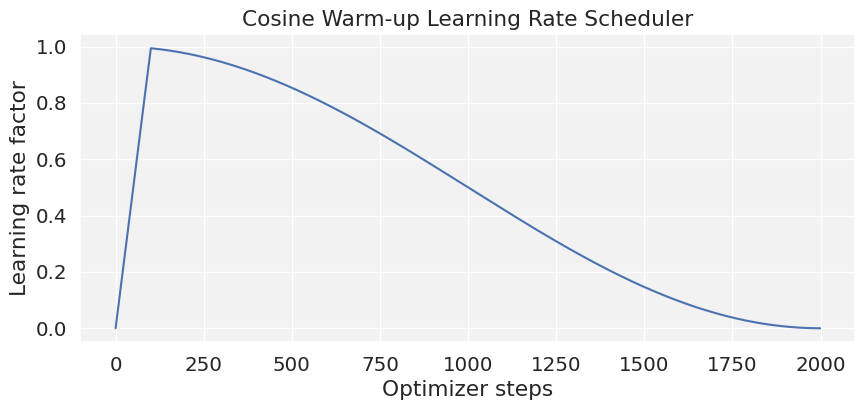

In [190]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = torch.optim.Adam([p], lr=1e-3)
lr_scheduler = CosineAnnealingWithWarmupLR(optimizer=optimizer, warmup_steps=100, max_steps=2000)

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
steps = range(2000)

ax.plot(steps, [lr_scheduler.get_lr_factor(e) for e in steps])
ax.set_ylabel("Learning rate factor")
ax.set_xlabel("Optimizer steps")
ax.set_title("Cosine Warm-up Learning Rate Scheduler");

**Задание 6 (0.1 балла):** обучите модель-классификатор палиндромов.

In [191]:
# useful utility class for computing averages
class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_epoch(model, optimizer, loader, scheduler=None, device='cpu'):
    model.train()
    loss_m = AverageMeter()
    acc_m = AverageMeter()
    epoch_lrs = []
    for inputs, targets in tqdm(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze(-1)
        loss = F.binary_cross_entropy_with_logits(outputs, targets.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # get accuracy
        acc = torch.eq(outputs.view(-1) > 0.0, targets).float().mean()
        # update stats
        loss_m.update(loss.item(), inputs.shape[0])
        acc_m.update(acc.item(), inputs.shape[0])
        epoch_lrs += [optimizer.param_groups[0]['lr']]
        # we use step-wise scheduler
        if scheduler is not None:
            scheduler.step()
    return loss_m.avg, acc_m.avg, epoch_lrs


@torch.no_grad()
def val_epoch(model, loader, device='cpu'):
    model.eval()
    loss_m = AverageMeter()
    acc_m = AverageMeter()
    for inputs, targets in tqdm(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze(-1)
        loss = F.binary_cross_entropy_with_logits(outputs, targets.float())
        # get accuracy
        acc = torch.eq(outputs.view(-1) > 0.0, targets).float().mean()
        # update stats
        loss_m.update(loss.item(), inputs.shape[0])
        acc_m.update(acc.item(), inputs.shape[0])
    return loss_m.avg, acc_m.avg


def plot_history(train_losses, train_accs, val_losses, val_accs, lrs, figsize=(18, 6)):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    ax[0].plot(train_losses, label='train')
    ax[0].plot(val_losses, label='val')
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].legend()

    ax[1].plot(train_accs, label='train')
    ax[1].plot(val_accs, label='val')
    ax[1].set_xlabel('Epoch', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].legend()

    ax[2].plot(lrs)
    ax[2].set_xlabel('Step', fontsize=16)
    ax[2].set_ylabel('Learning rate', fontsize=16)

    fig.tight_layout()
    plt.show()


def train(
    model,
    num_epochs,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    device='cpu'
):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    lrs = []
    for i in range(num_epochs):
        # run train epoch
        train_loss, train_acc, epoch_lrs = train_epoch(model, optimizer, train_loader, scheduler, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # run val epoch
        val_loss, val_acc = val_epoch(model, val_loader, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        # update lr
        lrs += epoch_lrs

        clear_output()
        plot_history(train_losses, train_accs, val_losses, val_accs, lrs)


def hardcode_parameters(module: nn.Module):
    for i, layer in enumerate(module.modules()):
        if isinstance(layer, nn.Linear):
            dim_out, dim_in = layer.weight.shape
            layer.weight.data = torch.cos(i * torch.arange(dim_out))[:, None] \
                * torch.cos(i * torch.arange(dim_in))[None, :]
            if layer.bias is not None:
                layer.bias.data.fill_(0)


Зададим параметры обучения и оптимизатора

In [192]:
num_epochs = 50
warmup_steps = 420
lr = 5e-5

In [193]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)

scheduler = CosineAnnealingWithWarmupLR(
    optimizer,
    warmup_steps=warmup_steps,
    max_steps=int(num_epochs * len(train_loader))
)

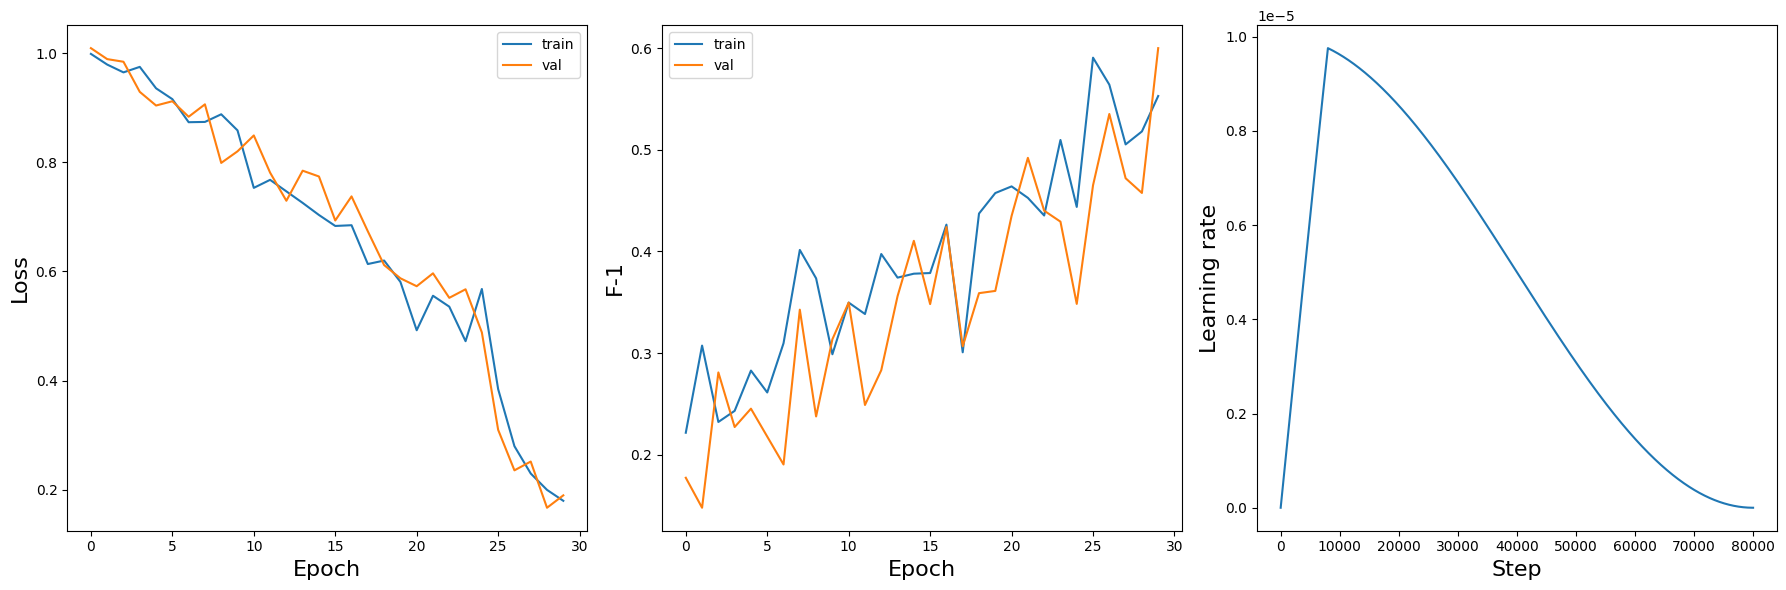

In [10]:
train(
    model,
    num_epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=test_loader,
    device=device
)